## Simulate a 2D Sedov Blast Wave

The following steps create an MPI cluster and then use the Ramses astrophysical MHD code to compute the Sedov-Taylor blast wave, a popular demonstration problem in fluid mechanics.
After the output is generated, the analysis tools provided with the Ramses code are used to plot a pseudocolor plot of the 2D results

### Spin-Up MPI cluster

The first step is to import Camber and initialize the MPI cluster:

In [1]:
import camber

Next, download the public Ramses repo if you do not already have it in your local directory

In [2]:
!git clone https://github.com/ramses-organisation/ramses.git

Cloning into 'ramses'...
remote: Enumerating objects: 24808, done.
remote: Counting objects: 100% (1217/1217), done.
remote: Compressing objects: 100% (690/690), done.
remote: Total 24808 (delta 485), reused 1086 (delta 460), pack-reused 23591 (from 1)
Receiving objects: 100% (24808/24808), 98.93 MiB | 40.57 MiB/s, done.
Resolving deltas: 100% (16416/16416), done.
Updating files: 100% (976/976), done.


In [3]:
# import some python packages and Ramses modules
import matplotlib.pyplot as plt
import numpy as np
import ramses.utils.py.ramses_io as ram

Now create an MPI job to compile `Ramses`.
This step ensures the code compiles with the correct MPI environment:

In [4]:
compile_job = camber.mpi.create_job(
    command="cd ramses/bin && make clean && make NDIM=2 MPI=1",
    engine_size="SMALL"
)

Check the `compile_job` output to monitor the job status

In [8]:
compile_job

CamberJob({"job_id": 7224, "status": "COMPLETED", "engine_size": "SMALL", "engine_type": "MPI", "command": "cd ramses/bin && make clean && make NDIM=2 MPI=1", "with_gpu": false})

Once the job status turns to `COMPLETED`, use `read_logs()` to check the output:

In [9]:
compile_job.read_logs(tail_lines=5)

mpif90 -ffree-line-length-none -fimplicit-none -O3 -cpp -DNVECTOR=32 -DNDIM=2 -DNPRE=8 -DNENER=0 -DNVAR=2+2+0+0+0 -DSOLVERhydro -c ../poisson/output_poisson.f90 -o output_poisson.o
mpif90 -ffree-line-length-none -fimplicit-none -O3 -cpp -DNVECTOR=32 -DNDIM=2 -DNPRE=8 -DNENER=0 -DNVAR=2+2+0+0+0 -DSOLVERhydro -c ../amr/ramses.f90 -o ramses.o
mpif90 -ffree-line-length-none -fimplicit-none -O3 mpi_mod.o amr_parameters.o amr_commons.o random.o pm_parameters.o sink_feedback_parameters.o pm_commons.o poisson_parameters.o dump_utils.o constants.o file_module.o poisson_commons.o hydro_parameters.o hydro_commons.o cooling_module.o bisection.o sparse_mat.o clfind_commons.o gadgetreadfile.o write_makefile.o write_patch.o write_gitinfo.o sink_sn_feedback.o read_params.o init_amr.o init_time.o init_refine.o tracer_utils.o adaptive_loop.o amr_step.o update_time.o output_amr.o flag_utils.o physical_boundaries.o virtual_boundaries.o refine_utils.o nbors_utils.o hilbert.o load_balance.o title.o sort.o c

### Run the MPI job

After compilation finishes, use the create_job method to start the Sedov-Taylor simulation using the Ramses binary and appropriate input file:

In [10]:
# run on camber with a medium instance
run_job = camber.mpi.create_job(
    command="mpirun -np 16 ramses/bin/ramses2d ramses/namelist/sedov2d.nml",
    engine_size="MEDIUM"
)

In [15]:
# check job status
run_job

CamberJob({"job_id": 7225, "status": "COMPLETED", "engine_size": "MEDIUM", "engine_type": "MPI", "command": "mpirun -np 16 ramses/bin/ramses2d ramses/namelist/sedov2d.nml", "with_gpu": false})

In [16]:
# you can write the output to a file with the job number
run_job.download_log()

In [17]:
# or you can view it in the notebook
run_job.read_logs(tail_lines=40)

 Level  8 has       1832 grids (      82,     155,     114,)
 Level  9 has       3311 grids (     160,     247,     206,)
 Level 10 has       4652 grids (     192,     365,     290,)
 Main step=   1483 mcons= 0.00E+00 econs= 1.11E-16 epot= 0.00E+00 ekin= 2.50E-01
 Fine step=   2966 t= 1.00066E+00 dt= 7.496E-04 a= 1.000E+00 mem= 1.3%
 Run completed
 Total elapsed time:   4.7743098250000005
 --------------------------------------------------------------------

     minimum       average       maximum  standard dev        std/av       %   rmn   rmx  TIMER
       0.429         0.430         0.430         0.000         0.001     8.8    11   1    coarse levels
       0.845         0.849         0.868         0.005         0.006    17.4     1  16    refine
       0.531         0.531         0.532         0.000         0.000    10.9     9  16    load balance
       0.009         0.012         0.018         0.002         0.167     0.3     9  16    particles
       0.190         0.190         0.

Now use Ramses' built-in utilities to analyze the simulations results in the notebook

In [18]:
# cd to ramses/utils/f90, compile utils, and return to current directory
!cd ramses/utils/f90 && make && cd -

gfortran -w -ffree-line-length-none -std=f2008 -Ofast -Wall -x f95-cpp-input -c random.f90 -o random.o
gfortran -w -ffree-line-length-none -std=f2008 -Ofast -Wall -x f95-cpp-input -c utils.f90 -o utils.o
gfortran -w -ffree-line-length-none -std=f2008 -Ofast -Wall -x f95-cpp-input -c io_ramses.f90 -o io_ramses.o
gfortran -w -ffree-line-length-none -std=f2008 -Ofast -Wall -x f95-cpp-input -c amr2prof.f90 -o amr2prof.o
gfortran  random.o utils.o io_ramses.o amr2prof.o -o ./amr2prof
gfortran -w -ffree-line-length-none -std=f2008 -Ofast -Wall -x f95-cpp-input -c amr2cylprof.f90 -o amr2cylprof.o
gfortran  random.o utils.o io_ramses.o amr2cylprof.o -o ./amr2cylprof
gfortran -w -ffree-line-length-none -std=f2008 -Ofast -Wall -x f95-cpp-input -c ramses2tipsy.f90 -o ramses2tipsy.o
gfortran  random.o utils.o io_ramses.o ramses2tipsy.o -o ./ramses2tipsy
gfortran -w -ffree-line-length-none -std=f2008 -Ofast -Wall -x f95-cpp-input -c amr2map.f90 -o amr2map.o
gfortran  random.o utils.o io_ramses.o am

In [20]:
# run amr2map to generate the 2d density map
!ramses/utils/f90/amr2map -inp output_00002 -out dens.map -typ 1

   1.00000000       1.00000000       1.00000000    
 ordering type=             hilbert
 time=   1.0006641445982500     
 Working resolution =        1024
 Processing file output_00002/amr_00002.out00001
 Processing file output_00002/amr_00002.out00002
 Processing file output_00002/amr_00002.out00003
 Processing file output_00002/amr_00002.out00004
 Processing file output_00002/amr_00002.out00005
 Processing file output_00002/amr_00002.out00006
 Processing file output_00002/amr_00002.out00007
 Processing file output_00002/amr_00002.out00008
 Processing file output_00002/amr_00002.out00009
 Processing file output_00002/amr_00002.out00010
 Processing file output_00002/amr_00002.out00011
 Processing file output_00002/amr_00002.out00012
 Processing file output_00002/amr_00002.out00013
 Processing file output_00002/amr_00002.out00014
 Processing file output_00002/amr_00002.out00015
 Processing file output_00002/amr_00002.out00016
 max value (code units)=   19.120367253027784     
 Norm=   1

Now generate a 2D plot of the results

Text(0.5, 1.0, 'log density')

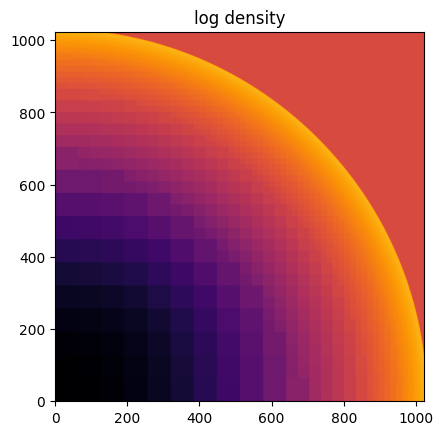

In [23]:
d=ram.rd_map("dens.map")
plt.imshow(np.log(d.data), origin="lower", cmap='inferno')
plt.title("log density")